# Baseline

In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

geopandas==0.13.2
lightgbm==4.1.0
numpy==1.25.2
pandas==1.5.3
pandas-datareader==0.10.0
pandas-gbq==0.19.2
pandas-stubs==1.5.3.230304
scikit-learn==1.2.2
sklearn-pandas==2.2.0


## Загрузка данных

In [ ]:
train_df = pd.read_parquet("train_data.pqt")
test_df = pd.read_parquet("test_data.pqt")

In [ ]:
train_df.head(9)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other}
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,NaN,...,0.945281,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},{other}
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,NaN,...,0.946066,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other}
5,1,month_3,-0.090605,-0.114275,-0.114119,-0.089937,channel_code_2,city_14,city_type_0,NaN,...,0.948027,0.488221,0.043221,0.560788,0.707687,-0.167905,0.259011,0.605309,{other},{other}
6,2,month_1,-0.154685,-0.186795,-0.122805,-0.154215,channel_code_12,city_613,city_type_306,NaN,...,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.178674,0.252657,0.440474,{α},{α}
7,2,month_2,-0.152784,-0.193686,-0.122805,-0.152308,channel_code_12,city_613,city_type_306,NaN,...,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.177854,0.252657,0.440474,{α},{α}
8,2,month_3,-0.148737,-0.187003,-0.112416,-0.148249,channel_code_12,city_613,city_type_306,NaN,...,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.176302,0.252368,0.429485,{α},{α}


In [ ]:
test_df.head(9)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,NaN,...,0.010952,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α}
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,NaN,...,0.006812,0.945281,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α}
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,NaN,...,0.006812,0.945281,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,{α}
3,200001,month_4,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,NaN,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
4,200001,month_5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,NaN,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
5,200001,month_6,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,NaN,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
6,200002,month_4,-0.096506,0.185905,-0.125995,-0.095856,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.510730,0.950774,0.545693,0.715525,0.554913,0.718798,0.445811,0.254968,0.495419,{α}
7,200002,month_5,0.572242,1.502779,-0.125995,0.574963,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.499912,0.949989,0.522704,2.442243,0.563940,0.841020,3.313686,0.256701,0.550364,{α}
8,200002,month_6,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.123154,0.946850,0.453739,2.614870,0.565087,0.818798,4.449125,0.258723,0.627287,{α}


In [ ]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]

Обозначение категориальных признаков

In [ ]:
train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

Создаем выборки для валидации и обучения

In [ ]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.1,
                                                  random_state=42)

In [ ]:
X

,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,...,0.186820,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}"
1,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,...,0.125043,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}"
2,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,...,0.033607,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}"
3,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,NaN,0.324343,1.258747,...,-0.024561,0.945281,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other}
4,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,NaN,0.324343,1.258747,...,-0.023981,0.946066,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,-0.156775,-0.204960,-0.125987,-0.156311,channel_code_9,city_14,city_type_0,NaN,0.324343,-1.064270,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{}
599996,-0.156776,-0.204960,-0.125995,-0.156312,channel_code_9,city_14,city_type_0,NaN,0.324343,-1.064270,...,-0.028584,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α}
599997,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,1.717879,1.762067,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{}
599998,-0.156712,-0.204913,-0.125831,-0.156248,channel_code_14,city_1876,city_type_0,index_city_code_195,1.717879,1.762067,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{}


## Обучение модели

В качестве базовой модели возьмем LGBM обучим на всех признаках

In [ ]:
model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

Зададим функцию для взвешенной метрики roc auc

In [ ]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [ ]:
cluster_weights = pd.read_excel("cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [ ]:
y_pred_proba = model.predict_proba(x_val)
y_pred_proba.shape

(60000, 17)

In [ ]:
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.7377486676909178

## Прогноз на тестовой выборке

In [ ]:
test_df.pivot(index="id", columns="date", values="start_cluster").head(3)

date,month_4,month_5,month_6
id,,,
200000,{α},{α},NaN
200001,{α},{α},NaN
200002,{other},{other},NaN


Для того, чтобы сделать прогноз на тестовой выборке, нужно заполнить стартовый кластер. </br>
В качестве базового подхода заполним все стартовые кластеры, самым популярным кластером.

In [ ]:
test_df["start_cluster"] = train_df["start_cluster"].mode()[0]
test_df["start_cluster"] = test_df["start_cluster"].astype("category")

In [ ]:
sample_submission_df = pd.read_csv("sample_submission.csv")

In [ ]:
sample_submission_df.shape

(100000, 18)

In [ ]:
sample_submission_df.head()

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
1,200001,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2,200002,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
3,200003,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
4,200004,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


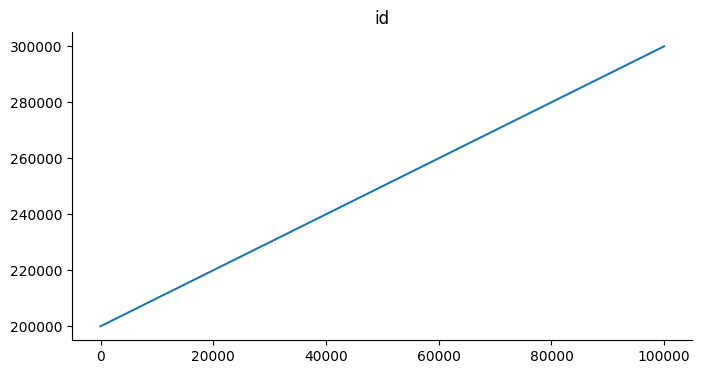

In [ ]:
# @title id

from matplotlib import pyplot as plt
sample_submission_df['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

Для тестовой выборки будем использовать только последний месяц

In [ ]:
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)

In [ ]:
test_pred_proba = model.predict_proba(last_m_test_df)
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

In [ ]:
test_pred_proba_df.shape

(100000, 17)

In [ ]:
test_pred_proba_df.head(2)

,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,0.006189,0.012050,0.015741,0.01508,0.001319,1.362490e-07,4.936810e-07,0.0,0.001405,0.002842,0.013719,0.000000e+00,0.000243,0.0,0.000022,0.931389,0.0
1,0.007152,0.599557,0.001526,0.00409,0.000032,2.712461e-05,0.000000e+00,0.0,0.000967,0.009810,0.004060,7.537570e-08,0.000066,0.0,0.000748,0.371965,0.0


In [ ]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("baseline_submission.csv", index=False)

In [ ]:
r = pd.read_csv('baseline_submission.csv')
r

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,6.188890e-03,1.205020e-02,1.574056e-02,1.508012e-02,1.319337e-03,1.362490e-07,4.936810e-07,0.0,1.404706e-03,2.842366e-03,1.371898e-02,0.000000e+00,2.427292e-04,0.0,2.245898e-05,9.313890e-01,0.0
1,200001,7.152335e-03,5.995575e-01,1.525838e-03,4.090054e-03,3.222050e-05,2.712461e-05,0.000000e+00,0.0,9.671802e-04,9.809590e-03,4.060278e-03,7.537570e-08,6.562697e-05,0.0,7.475112e-04,3.719647e-01,0.0
2,200002,1.762723e-12,1.554666e-12,3.047521e-13,2.546667e-12,2.828524e-13,6.094937e-17,2.064687e-17,0.0,1.024317e-12,4.851597e-14,1.996503e-11,0.000000e+00,1.000000e+00,0.0,5.585427e-21,3.868509e-11,0.0
3,200003,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
4,200004,4.073865e-02,1.096241e-01,3.852915e-03,1.075554e-02,2.159642e-03,2.401301e-05,5.581718e-08,0.0,1.256553e-03,1.185656e-01,7.182867e-03,0.000000e+00,2.306480e-03,0.0,7.282099e-05,7.034608e-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,3.208271e-02,2.706943e-01,2.207109e-03,1.272893e-02,3.434033e-04,3.552788e-06,1.177955e-06,0.0,3.855541e-03,4.086310e-03,1.795058e-03,1.420761e-06,3.627166e-04,0.0,4.070348e-04,6.714307e-01,0.0
99996,299996,2.555772e-02,5.006492e-02,1.868961e-02,3.389017e-02,1.050278e-03,1.884597e-03,1.589691e-08,0.0,3.336434e-03,4.700005e-03,5.189969e-03,3.971321e-06,1.393749e-04,0.0,4.026567e-04,8.550903e-01,0.0
99997,299997,3.739021e-02,1.879060e-02,1.026377e-02,5.131535e-02,9.082577e-03,1.481714e-05,5.923431e-06,0.0,2.911768e-02,3.617934e-03,7.400590e-03,0.000000e+00,2.078788e-04,0.0,5.755073e-03,8.270376e-01,0.0
99998,299998,4.982686e-90,5.871266e-89,2.391233e-90,6.052903e-90,3.319366e-91,1.153645e-94,7.612337e-174,0.0,1.480453e-90,1.269204e-90,2.420764e-90,2.942134e-93,2.355762e-91,0.0,6.702763e-92,1.000000e+00,0.0


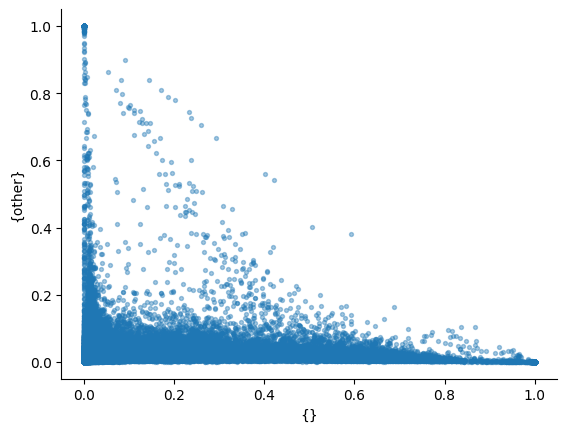

In [ ]:
# @title {} vs {other}

from matplotlib import pyplot as plt
r.plot(kind='scatter', x='{}', y='{other}', s=8, alpha=.4)
plt.gca().spines[['top', 'right',]].set_visible(False)